<h1> Code Vulnerabilities Detection Using CodeBert </h1>

<p>Ratnaker Gautam</p>

## Overview<a name='toc'></a>
<ol>
<li><a href='#load'> Data Analysis and Preprocessing</a></li>
<li><a href='#bert'>СodeBert</a></li>
</ol>

In [81]:
from tqdm import tqdm, trange
import multiprocessing

from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForMaskedLM, pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import torch

!pip install evaluate
import evaluate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

### 1. Data Loading and Preparation 
Dataset<a name='load'></a>

[SARD](https://www.kaggle.com/datasets/cerengen/securec-c-source-code-for-vulnerabilty-detection/)

The Software Assurance Reference Dataset (SARD) is a growing collection of test programs with documented vulnerabilities in the code. Test examples range from small synthetic programs to large applications. The programs are written in C, C++, Java, PHP, and C# and cover more than 150 classes of vulnerabilities.

A collection of more than 450,000 examples of vulnerabilities;
Covers over 150 classes of Common Weakness Enumeration (CWE)

In [29]:
pd.set_option('max_colwidth', 400)
df = pd.read_csv('/kaggle/input/llm-code-vulnerability/multi_sard_all_data_marked.csv')
df.head()

,code,CWE-Type,DataType
0,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD
1,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD
2,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD
3,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD
4,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD


In [30]:
unique = len(df['CWE-Type'].unique())
print(f'Number of Records in the Dataset: {len(df)}')
print(f'Types of CWE: {unique}')


Number of Records in the Dataset: 52802
Types of CWE: 109


In [31]:
id2label = dict()
label2id = dict()
ind = 0
for i in df['CWE-Type'].unique():
    id2label[ind] = i
    label2id[i] = ind
    ind+=1

In [32]:
df['label']=df['CWE-Type'].map(label2id)
df.head()

,code,CWE-Type,DataType,label
0,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD,0
1,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD,0
2,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD,0
3,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD,0
4,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD,0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


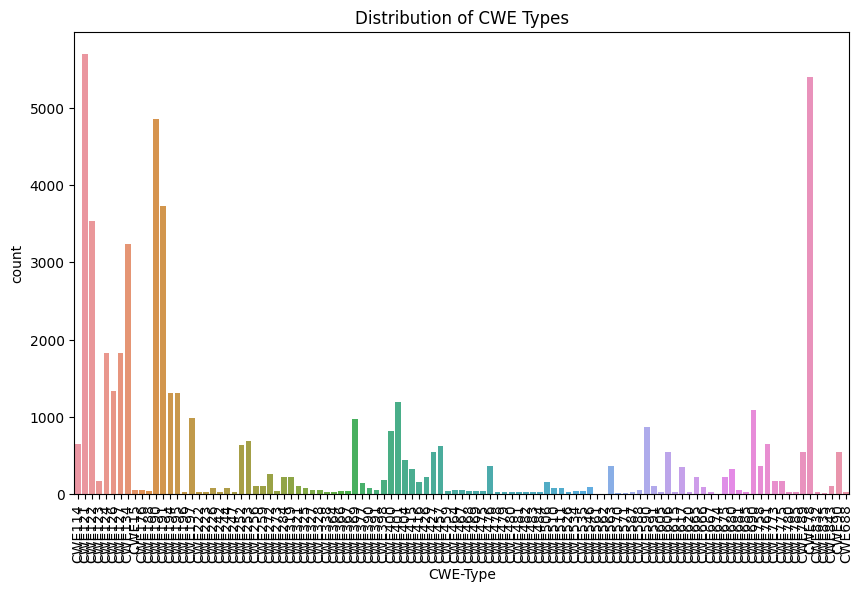

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizing the data distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CWE-Type')
plt.xticks(rotation=90)
plt.title('Distribution of CWE Types')
plt.show()

**Split the dataset into training and holdout samples**



In [34]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

### 2. CodeBert <a name='bert'></a>

To load the data, we will use the Datasets library.

Datasets is a library for easy access to datasets and their collaborative use for audio, computer vision, and natural language processing (NLP) tasks.

It allows for the loading of datasets and the use of built-in data processing methods to prepare datasets for use in training neural network models. The library supports the Apache Arrow format and processes large datasets without any memory constraints for optimal speed and efficiency. Also, the library is integrated with the Hugging Face Hub, which makes it easy to load a dataset and share it with the community.



In [ ]:
dataset = {}
dataset['text'] = list(df_train['code'])
dataset['label'] = list(df_train['label'])
ds = Dataset.from_dict(dataset)
ds = ds.train_test_split(test_size=0.1)

**Tokenize the input sequences with program text using the trained tokenizer Codebert-base-mlm**

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm')

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = ds.map(preprocess_function, batched=True)

**Data Collator**

Data Collators are objects that will form batches (data portions) using a list of dataset elements as input. These elements are of the same type as the elements in train_dataset or eval_dataset.

To be able to create batches, data collators can apply some processing (such as padding).

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

**Evaluate**
Data Collators are objects that will form batches (data portions) using a list of dataset elements as input. These elements are of the same type as the elements in train_dataset or eval_dataset.

To be able to create batches, data collators can apply some processing (such as padding).

In [11]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

[CodeBert](https://github.com/microsoft/CodeBERT)

A pre-trained model taken from a research paper by Microsoft's research division. This model was trained using the CodeSearchNet dataset, but instead of generating comments, it was used to train the model on a RoBERTa-based representation of code and natural language that is easy to understand.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base-mlm", num_labels=109, id2label=id2label, label2id=label2id
)

The Trainer class provides a full-featured PyTorch training API for most standard use cases.

Before creating a Trainer instance, it is necessary to create training arguments to access all customization points during training.

The API supports distributed training on multiple GPUs, mixed precision using NVIDIA Apex, and a native accelerator for PyTorch.

Trainer contains the basic training loop that supports the aforementioned features. To implement custom functions, the following methods can be overridden:

- get_train_dataloader — Creates the training DataLoader.
- get_eval_dataloader — Creates the evaluation DataLoader.
- get_test_dataloader — Creates the test DataLoader.
- log — Logs information on the various objects watching training.
- create_optimizer_and_scheduler — Sets up the optimizer and learning rate scheduler if they were not passed at - init. Note, that you can also subclass or override the create_optimizer and create_scheduler methods separately.
- create_optimizer — Sets up the optimizer if it wasn’t passed at init.
- create_scheduler — Sets up the learning rate scheduler if it wasn’t passed at init.
- compute_loss - Computes the loss on a batch of training inputs.
- training_step — Performs a training step.
- prediction_step — Performs an evaluation/test step.
- evaluate — Runs an evaluation loop and returns metrics.
- predict — Returns predictions (with metrics if labels are available) on a test set.

In [ ]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

### Testing a Trained Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [ ]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [25]:
ls

trained_model/  wandb/


In [27]:
!zip wandb wandb

  adding: wandb/ (stored 0%)


In [28]:
!zip trained_model trained_model

  adding: trained_model/ (stored 0%)


In [29]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/wandb/ (stored 0%)
  adding: kaggle/working/wandb/debug.log (deflated 78%)
  adding: kaggle/working/wandb/run-20240209_111011-un28gv5b/ (stored 0%)
  adding: kaggle/working/wandb/run-20240209_111011-un28gv5b/tmp/ (stored 0%)
  adding: kaggle/working/wandb/run-20240209_111011-un28gv5b/tmp/code/ (stored 0%)
  adding: kaggle/working/wandb/run-20240209_111011-un28gv5b/files/ (stored 0%)
  adding: kaggle/working/wandb/run-20240209_111011-un28gv5b/files/requirements.txt (deflated 58%)
  adding: kaggle/working/wandb/run-20240209_111011-un28gv5b/files/config.yaml (deflated 77%)
  adding: kaggle/working/wandb/run-20240209_111011-un28gv5b/files/wandb-metadata.json (deflated 65%)
  adding: kaggle/working/wandb/run-20240209_111011-un28gv5b/files/wandb-summary.json (deflated 51%)
  adding: kaggle/working/wandb/run-20240209_111011-un28gv5b/files/conda-environment.yaml (deflated 67%)
  adding: kaggle/working/wandb/run-20240209_111011-un28

In [27]:
pd.set_option('max_colwidth', 400)
df = pd.read_csv('/kaggle/input/llm-code-vulnerability/multi_sard_all_data_marked.csv')
df.head()

,code,CWE-Type,DataType
0,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD
1,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD
2,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD
3,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD
4,"\n \n \n #include ""IncludeMarker""\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, ""ws2_32"") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...",CWE114,SARD


In [28]:
unique = len(df['CWE-Type'].unique())
print(f'Number of Records in the Dataset: {len(df)}')
print(f'Types of CWE: {unique}')

Number of Records in the Dataset: 52802
Types of CWE: 109


In [30]:
# Remove "CWE" from the CWE-Type column and convert to integers
df['CWE-Type'] = df['CWE-Type'].str.replace('CWE', '').astype(int)

# Filter the dataset
filtered_df = df[(df['CWE-Type'].isin([121, 122, 123, 124, 476])) | (df['CWE-Type'].between(780, 790))]

# Print the filtered DataFrame
print(filtered_df)


                                                                                                                                                                                                                                                                                                                                                                                                                  code  \
648    \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n #endif \n \n \n \n #ifdef INC...   
649    \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct 

In [31]:
# Convert CWE-Type back to string and add "CWE" prefix
filtered_df['CWE-Type'] = 'CWE' + filtered_df['CWE-Type'].astype(str)

# Print the filtered DataFrame
print(filtered_df)

                                                                                                                                                                                                                                                                                                                                                                                                                  code  \
648    \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n #endif \n \n \n \n #ifdef INC...   
649    \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct 

/tmp/ipykernel_42/1103959830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['CWE-Type'] = 'CWE' + filtered_df['CWE-Type'].astype(str)


In [32]:
df=filtered_df

In [33]:
df.head()

,code,CWE-Type,DataType
648,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n #endif \n \n \n \n #ifdef INC...",CWE121,SARD
649,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n \n \n \n #endif \n \n \n \n #...",CWE121,SARD
650,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n \n \n \n #endif \n \n \n \n #...",CWE121,SARD
651,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n \n static const int intMarker = 1; \n static const int intMarker = 0; \n \n #ifndef OMITBAD\n ...",CWE121,SARD
652,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n \n static int intMarker = 1; \n static int intMarker = 0; \n \n #ifndef OMITBAD\n \n \n #endif...",CWE121,SARD


In [34]:
df.to_csv('multi_sard_all_data_marked_filtered.csv')

In [35]:
unique = len(df['CWE-Type'].unique())
print(f'Number of Records in the Dataset: {len(df)}')
print(f'Types of CWE: {unique}')

Number of Records in the Dataset: 12156
Types of CWE: 8


In [36]:
id2label = dict()
label2id = dict()
ind = 0
for i in df['CWE-Type'].unique():
    id2label[ind] = i
    label2id[i] = ind
    ind+=1

In [37]:
df['label']=df['CWE-Type'].map(label2id)
df.head()

,code,CWE-Type,DataType,label
648,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n #endif \n \n \n \n #ifdef INC...",CWE121,SARD,0
649,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n \n \n \n #endif \n \n \n \n #...",CWE121,SARD,0
650,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n \n \n \n #endif \n \n \n \n #...",CWE121,SARD,0
651,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n \n static const int intMarker = 1; \n static const int intMarker = 0; \n \n #ifndef OMITBAD\n ...",CWE121,SARD,0
652,"\n \n \n #include ""IncludeMarker""\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker ""0123456789abcdef0123456789abcde""\n \n typedef struct _charVoid\n {\n char charMarkerArray[16];\n void * voidPointerMarker;\n void * voidPointerMarker;\n } charVoid;\n \n \n static int intMarker = 1; \n static int intMarker = 0; \n \n #ifndef OMITBAD\n \n \n #endif...",CWE121,SARD,0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


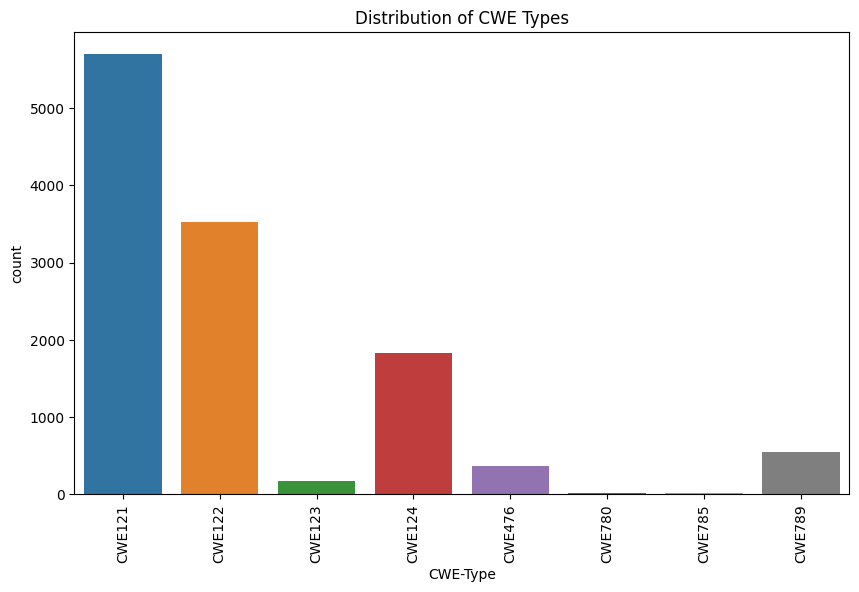

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizing the data distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CWE-Type')
plt.xticks(rotation=90)
plt.title('Distribution of CWE Types')
plt.show()

In [40]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [41]:
dataset = {}
dataset['text'] = list(df_train['code'])
dataset['label'] = list(df_train['label'])
ds = Dataset.from_dict(dataset)
ds = ds.train_test_split(test_size=0.1)

In [42]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm')

In [43]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = ds.map(preprocess_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [44]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [45]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [46]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base-mlm", num_labels=8, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.539300,0.201551,0.906475


TrainOutput(global_step=547, training_loss=0.5128518702561067, metrics={'train_runtime': 490.0292, 'train_samples_per_second': 17.858, 'train_steps_per_second': 1.116, 'total_flos': 2302608883949568.0, 'train_loss': 0.5128518702561067, 'epoch': 1.0})

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [49]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      CWE121       0.90      0.95      0.93      1172
      CWE122       0.99      0.87      0.93       694
      CWE123       1.00      1.00      1.00        28
      CWE124       0.84      0.88      0.86       372
      CWE476       1.00      0.87      0.93        53
      CWE780       1.00      1.00      1.00         3
      CWE785       0.00      0.00      0.00         5
      CWE789       0.95      1.00      0.98       105

    accuracy                           0.92      2432
   macro avg       0.84      0.82      0.83      2432
weighted avg       0.92      0.92      0.92      2432



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


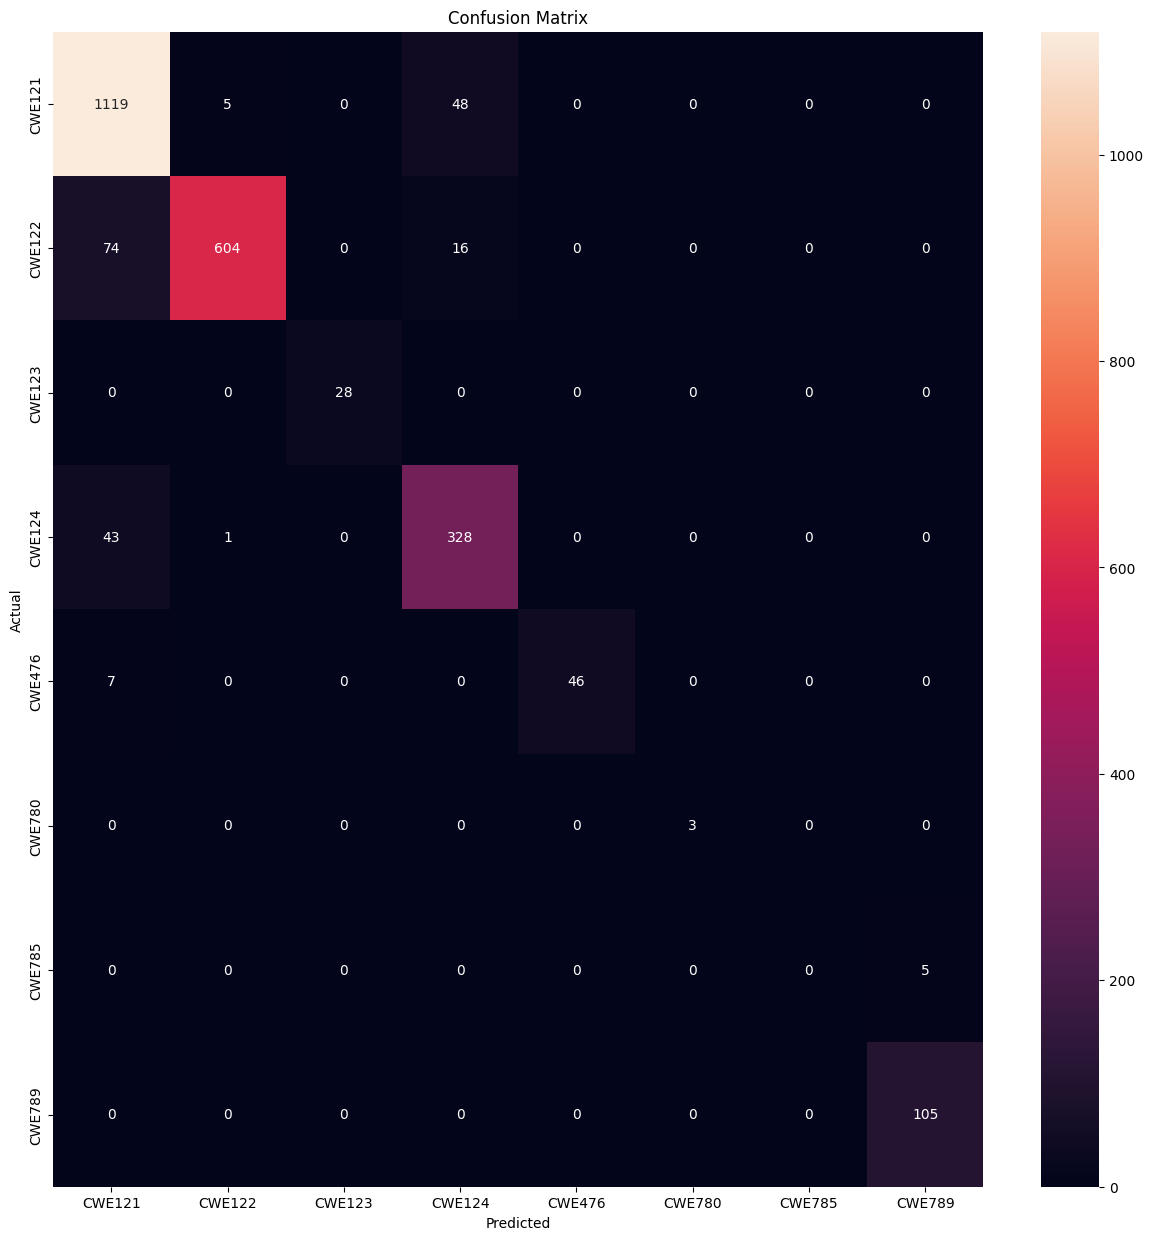

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

TRYING OTHER COMBINATIONS


In [53]:
from transformers import BertTokenizer, BertForMaskedLM

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [55]:
tokenized_dataset = ds.map(preprocess_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [56]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [57]:
accuracy = evaluate.load("accuracy")

In [58]:
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=8, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.611300,0.258260,0.900308


TrainOutput(global_step=547, training_loss=0.5835624830814341, metrics={'train_runtime': 491.887, 'train_samples_per_second': 17.791, 'train_steps_per_second': 1.112, 'total_flos': 2302608883949568.0, 'train_loss': 0.5835624830814341, 'epoch': 1.0})

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [61]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      CWE121       0.88      0.94      0.91      1172
      CWE122       0.94      0.89      0.91       694
      CWE123       1.00      1.00      1.00        28
      CWE124       0.85      0.77      0.81       372
      CWE476       0.94      0.87      0.90        53
      CWE780       0.00      0.00      0.00         3
      CWE785       0.00      0.00      0.00         5
      CWE789       1.00      1.00      1.00       105

    accuracy                           0.90      2432
   macro avg       0.70      0.68      0.69      2432
weighted avg       0.90      0.90      0.90      2432



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


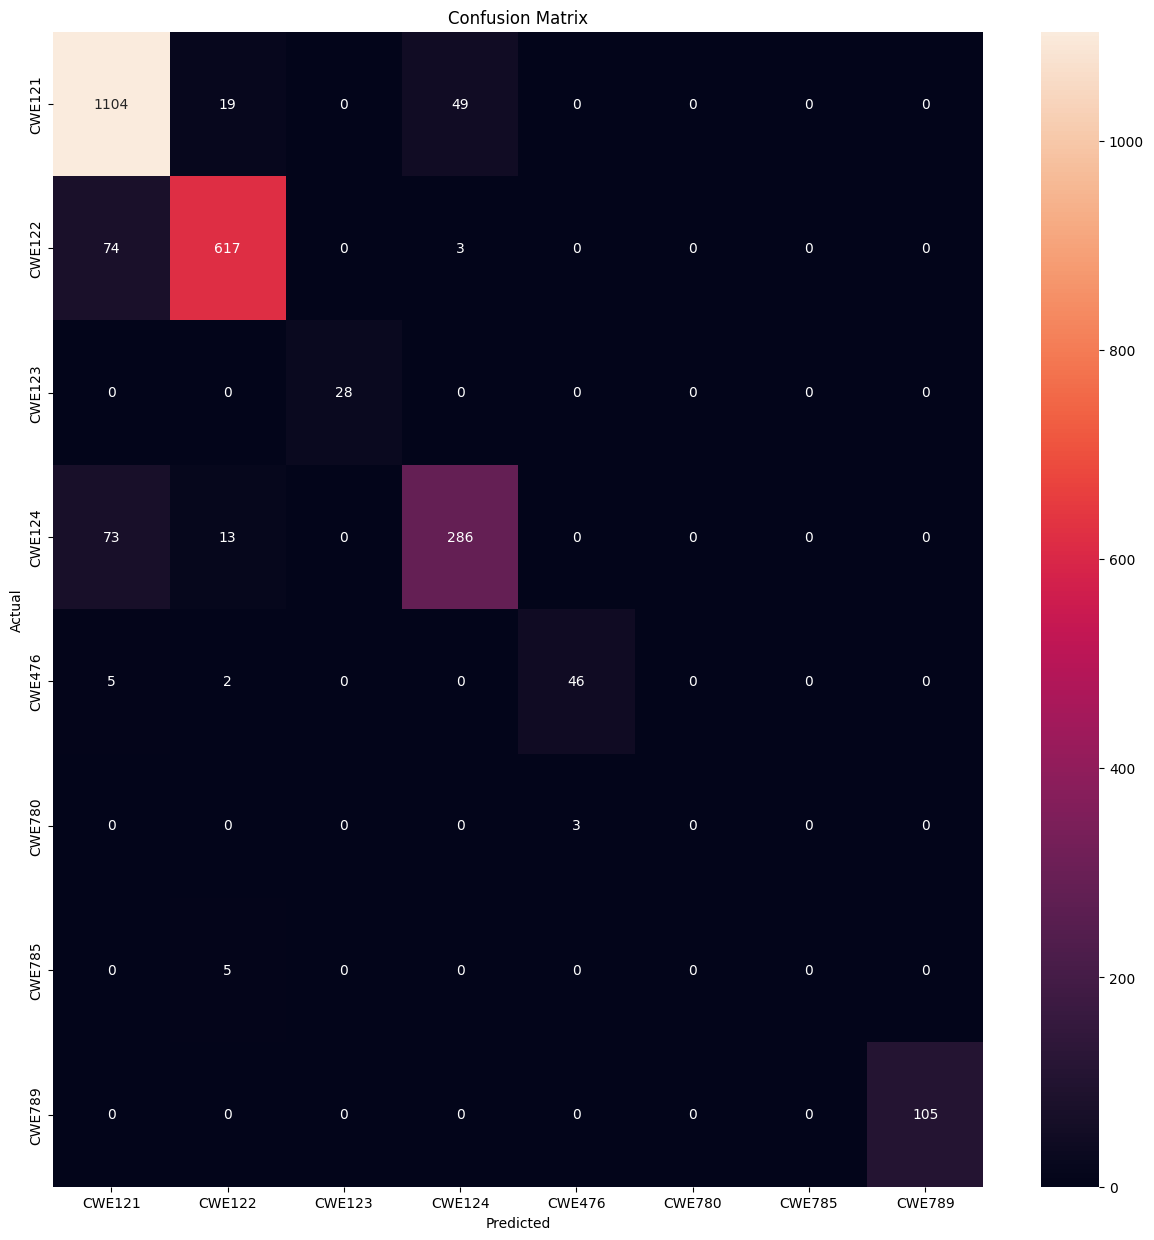

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [65]:
from transformers import DistilBertTokenizer, AutoModelForSequenceClassification

In [66]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') 
tokenized_dataset = ds.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=8, id2label=id2label, label2id=label2id
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.696000,0.286675,0.889003


TrainOutput(global_step=547, training_loss=0.6636258339751138, metrics={'train_runtime': 255.3876, 'train_samples_per_second': 34.266, 'train_steps_per_second': 2.142, 'total_flos': 1159346244132864.0, 'train_loss': 0.6636258339751138, 'epoch': 1.0})

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [69]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      CWE121       0.87      0.94      0.91      1172
      CWE122       0.98      0.88      0.92       694
      CWE123       1.00      1.00      1.00        28
      CWE124       0.81      0.80      0.81       372
      CWE476       0.93      0.77      0.85        53
      CWE780       0.00      0.00      0.00         3
      CWE785       0.00      0.00      0.00         5
      CWE789       1.00      1.00      1.00       105

    accuracy                           0.90      2432
   macro avg       0.70      0.67      0.69      2432
weighted avg       0.90      0.90      0.90      2432



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


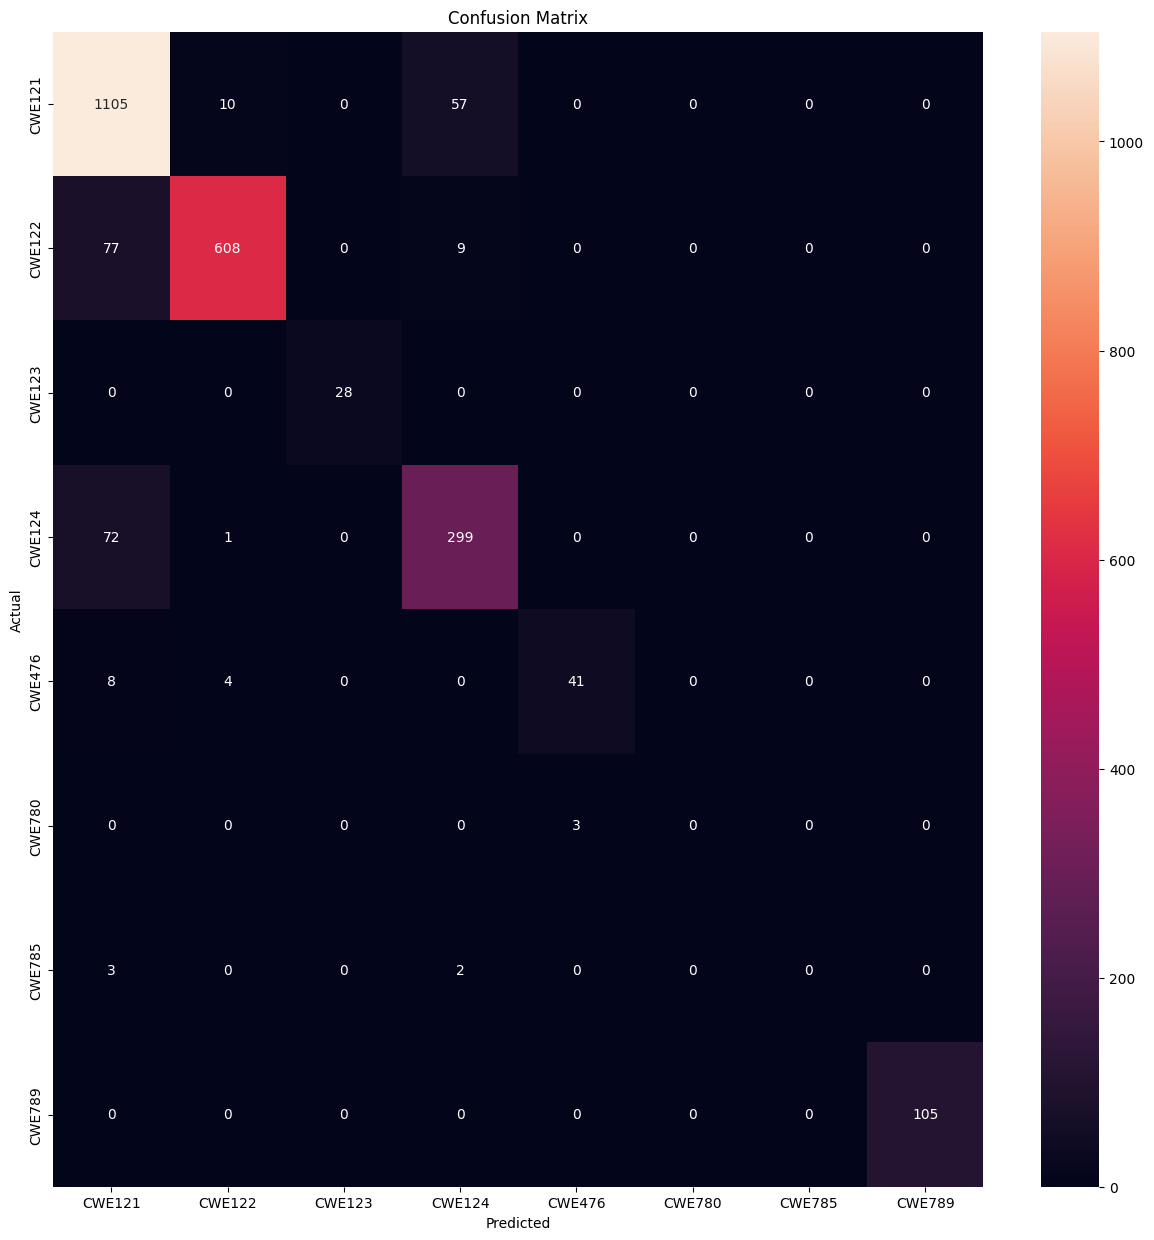

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

CODET5

In [5]:
def extract_cwe_number(cwe_type):
    return cwe_type[3:]  # Extract the digits after "CWE"

df['CWE-Type'] = df['CWE-Type'].apply(extract_cwe_number)

In [7]:
# Split dataset into training and validation sets
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)  # Adjust test_size as needed

In [16]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq

tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5-base')
model = AutoModelForSeq2SeqLM.from_pretrained('Salesforce/codet5-base')

def prepare_data(example):
    # Combine code and CWE label for seq2seq training
    input_text = example["code"]
    target_text = example["CWE-Type"]
    return tokenizer(input_text, target_text, truncation=True, padding=True)  

train_dataset = df_train.apply(prepare_data, axis=1) 
val_dataset = df_val.apply(prepare_data, axis=1)

In [17]:
data_collator = DataCollatorForSeq2Seq(model=model, tokenizer=tokenizer)


In [18]:
accuracy = evaluate.load("accuracy")

In [19]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,  
    # ... other arguments
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


KeyError: 15780

In [ ]:
def classify_code(code_snippet):
   inputs = tokenizer(code_snippet, return_tensors="pt")
   output = model.generate(**inputs)
   predicted_label = tokenizer.decode(output[0], skip_special_tokens=True)
   return predicted_label

DIVERSEVUL

In [94]:
import json

def load_json_lines(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                data.append(json.loads(line.strip()))
            except json.JSONDecodeError as e:
                print(f"Error decoding line: {e}")
    return data

data = load_json_lines('/kaggle/input/llm-code-vulnerability/diversevul_20230702.json')

KeyboardInterrupt: 

In [6]:
def create_csv(data, output_file):
    rows = []
    for item in data:
        func = item.get('func')
        cwe = item.get('cwe', [])  # Handle potential missing 'cwe'
        target = item.get('target')

        # Convert CWE list into a string 
        cwe_str = ",".join(cwe) 

        rows.append({'func': func, 'cwe': cwe_str, 'target': target})

    df = pd.DataFrame(rows)
    df.to_csv(output_file, index=False)

create_csv(data, 'processed_data_diversevul.csv')

In [95]:
df=pd.read_csv('/kaggle/input/llm-code-vulnerability/processed_data_diversevul.csv')

In [96]:
df.head()

,code,CWE-Type,target
0,"int _gnutls_ciphertext2compressed(gnutls_session_t session,\n\t\t\t\t opaque * compress_data,\n\t\t\t\t int compress_size,\n\t\t\t\t gnutls_datum_t ciphertext, uint8 type)\n{\n uint8 MAC[MAX_HASH_SIZE];\n uint16 c_length;\n uint8 pad;\n int length;\n mac_hd_t td;\n uint16 blocksize;\n int ret, i, pad_failed = 0;\n uint8 major, minor;\n gnutls_protocol_t ver;\n ...",CWE0,1.0
1,"static char *make_filename_safe(const char *filename TSRMLS_DC)\n{\n\tif (*filename && strncmp(filename, "":memory:"", sizeof("":memory:"")-1)) {\n\t\tchar *fullpath = expand_filepath(filename, NULL TSRMLS_CC);\n\n\t\tif (!fullpath) {\n\t\t\treturn NULL;\n\t\t}\n\n\t\tif (PG(safe_mode) && (!php_checkuid(fullpath, NULL, CHECKUID_CHECK_FILE_AND_DIR))) {\n\t\t\tefree(fullpath);\n\t\t\treturn NULL;\n\...",CWE264,1.0
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tIF_DESKTOP(long long total_written = 0;)\n\tIF_DESKTOP(long long) int retval = -1;\n\tunsigned char *stackp;\n\tlong code;\n\tint finchar;\n\tlong oldcode;\n\tlong incode;\n\tint inbits;\n\tint posbits;\n\tint outpos;\n\tint insize;\n\tint bitmask;\n\tlong free_ent;\n\tlong maxcode;\n\tlong maxmaxcode;\n\tint n_bits;\n\tint rsize = 0;\n\tunsigned ch...",CWE0,1.0
3,"static void cirrus_do_copy(CirrusVGAState *s, int dst, int src, int w, int h)\n{\n int sx, sy;\n int dx, dy;\n int width, height;\n int depth;\n int notify = 0;\n\n depth = s->get_bpp((VGAState *)s) / 8;\n s->get_resolution((VGAState *)s, &width, &height);\n\n /* extra x, y */\n sx = (src % (width * depth)) / depth;\n sy = (src / (width * depth));\n dx = (dst %...",CWE787,1.0
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusVGAState *s,\n uint8_t *dst,const uint8_t *src,\n int dstpitch,int srcpitch,\n int bltwidth,int bltheight)\n{\n int x,y;\n dstpitch -= bltwidth;\n srcpitch -= bltwidth;\n for (y = 0; y < bltheight; y++) {\n for (x = 0; x < bltwidth; x++) {\n ...",CWE787,1.0


In [97]:
df=df.drop('target',axis=1)

In [98]:
df.head()

,code,CWE-Type
0,"int _gnutls_ciphertext2compressed(gnutls_session_t session,\n\t\t\t\t opaque * compress_data,\n\t\t\t\t int compress_size,\n\t\t\t\t gnutls_datum_t ciphertext, uint8 type)\n{\n uint8 MAC[MAX_HASH_SIZE];\n uint16 c_length;\n uint8 pad;\n int length;\n mac_hd_t td;\n uint16 blocksize;\n int ret, i, pad_failed = 0;\n uint8 major, minor;\n gnutls_protocol_t ver;\n ...",CWE0
1,"static char *make_filename_safe(const char *filename TSRMLS_DC)\n{\n\tif (*filename && strncmp(filename, "":memory:"", sizeof("":memory:"")-1)) {\n\t\tchar *fullpath = expand_filepath(filename, NULL TSRMLS_CC);\n\n\t\tif (!fullpath) {\n\t\t\treturn NULL;\n\t\t}\n\n\t\tif (PG(safe_mode) && (!php_checkuid(fullpath, NULL, CHECKUID_CHECK_FILE_AND_DIR))) {\n\t\t\tefree(fullpath);\n\t\t\treturn NULL;\n\...",CWE264
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tIF_DESKTOP(long long total_written = 0;)\n\tIF_DESKTOP(long long) int retval = -1;\n\tunsigned char *stackp;\n\tlong code;\n\tint finchar;\n\tlong oldcode;\n\tlong incode;\n\tint inbits;\n\tint posbits;\n\tint outpos;\n\tint insize;\n\tint bitmask;\n\tlong free_ent;\n\tlong maxcode;\n\tlong maxmaxcode;\n\tint n_bits;\n\tint rsize = 0;\n\tunsigned ch...",CWE0
3,"static void cirrus_do_copy(CirrusVGAState *s, int dst, int src, int w, int h)\n{\n int sx, sy;\n int dx, dy;\n int width, height;\n int depth;\n int notify = 0;\n\n depth = s->get_bpp((VGAState *)s) / 8;\n s->get_resolution((VGAState *)s, &width, &height);\n\n /* extra x, y */\n sx = (src % (width * depth)) / depth;\n sy = (src / (width * depth));\n dx = (dst %...",CWE787
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusVGAState *s,\n uint8_t *dst,const uint8_t *src,\n int dstpitch,int srcpitch,\n int bltwidth,int bltheight)\n{\n int x,y;\n dstpitch -= bltwidth;\n srcpitch -= bltwidth;\n for (y = 0; y < bltheight; y++) {\n for (x = 0; x < bltwidth; x++) {\n ...",CWE787


In [15]:
# Remove the hyphen in the cwe column
df['cwe'] = df['cwe'].str.replace('-', '')

# Replace nan values in cwe column with CWE0
df['cwe'].fillna('CWE0', inplace=True)

df = df.rename(columns={'func': 'code', 'cwe': 'CWE-Type'}) 
# Print the dataframe (Optional)
print(df)

# Save to a new CSV file
df.to_csv("processed_data_diversevul.csv", index=False)

                                                     code CWE-Type  target
0       int _gnutls_ciphertext2compressed(gnutls_sessi...     CWE0     1.0
1       static char *make_filename_safe(const char *fi...   CWE264     1.0
2       unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...     CWE0     1.0
3       static void cirrus_do_copy(CirrusVGAState *s, ...   CWE787     1.0
4       glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...   CWE787     1.0
...                                                   ...      ...     ...
330500  CpuDefinitionInfoList *qmp_query_cpu_definitio...     CWE0     0.0
330501  static bool loongarch_cpu_exec_interrupt(CPUSt...     CWE0     0.0
330502  static bool loongarch_cpu_has_work(CPUState *c...     CWE0     0.0
330503  static void loongarch_cpu_add_definition(gpoin...     CWE0     0.0
330504  static void loongarch_cpu_synchronize_from_tb(...     CWE0     0.0

[330505 rows x 3 columns]


In [99]:
df = df.astype(str) 


In [100]:
unique = len(df['CWE-Type'].unique())
print(f'Number of Records in the Dataset: {len(df)}')
print(f'Types of CWE: {unique}')

Number of Records in the Dataset: 330505
Types of CWE: 626


In [101]:
id2label = dict()
label2id = dict()
ind = 0
for i in df['CWE-Type'].unique():
    id2label[ind] = i
    label2id[i] = ind
    ind+=1

In [102]:
df['label']=df['CWE-Type'].map(label2id)
df.head()
#df=df.drop('target',axis=1)

,code,CWE-Type,label
0,"int _gnutls_ciphertext2compressed(gnutls_session_t session,\n\t\t\t\t opaque * compress_data,\n\t\t\t\t int compress_size,\n\t\t\t\t gnutls_datum_t ciphertext, uint8 type)\n{\n uint8 MAC[MAX_HASH_SIZE];\n uint16 c_length;\n uint8 pad;\n int length;\n mac_hd_t td;\n uint16 blocksize;\n int ret, i, pad_failed = 0;\n uint8 major, minor;\n gnutls_protocol_t ver;\n ...",CWE0,0
1,"static char *make_filename_safe(const char *filename TSRMLS_DC)\n{\n\tif (*filename && strncmp(filename, "":memory:"", sizeof("":memory:"")-1)) {\n\t\tchar *fullpath = expand_filepath(filename, NULL TSRMLS_CC);\n\n\t\tif (!fullpath) {\n\t\t\treturn NULL;\n\t\t}\n\n\t\tif (PG(safe_mode) && (!php_checkuid(fullpath, NULL, CHECKUID_CHECK_FILE_AND_DIR))) {\n\t\t\tefree(fullpath);\n\t\t\treturn NULL;\n\...",CWE264,1
2,"unpack_Z_stream(int fd_in, int fd_out)\n{\n\tIF_DESKTOP(long long total_written = 0;)\n\tIF_DESKTOP(long long) int retval = -1;\n\tunsigned char *stackp;\n\tlong code;\n\tint finchar;\n\tlong oldcode;\n\tlong incode;\n\tint inbits;\n\tint posbits;\n\tint outpos;\n\tint insize;\n\tint bitmask;\n\tlong free_ent;\n\tlong maxcode;\n\tlong maxmaxcode;\n\tint n_bits;\n\tint rsize = 0;\n\tunsigned ch...",CWE0,0
3,"static void cirrus_do_copy(CirrusVGAState *s, int dst, int src, int w, int h)\n{\n int sx, sy;\n int dx, dy;\n int width, height;\n int depth;\n int notify = 0;\n\n depth = s->get_bpp((VGAState *)s) / 8;\n s->get_resolution((VGAState *)s, &width, &height);\n\n /* extra x, y */\n sx = (src % (width * depth)) / depth;\n sy = (src / (width * depth));\n dx = (dst %...",CWE787,2
4,"glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusVGAState *s,\n uint8_t *dst,const uint8_t *src,\n int dstpitch,int srcpitch,\n int bltwidth,int bltheight)\n{\n int x,y;\n dstpitch -= bltwidth;\n srcpitch -= bltwidth;\n for (y = 0; y < bltheight; y++) {\n for (x = 0; x < bltwidth; x++) {\n ...",CWE787,2


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


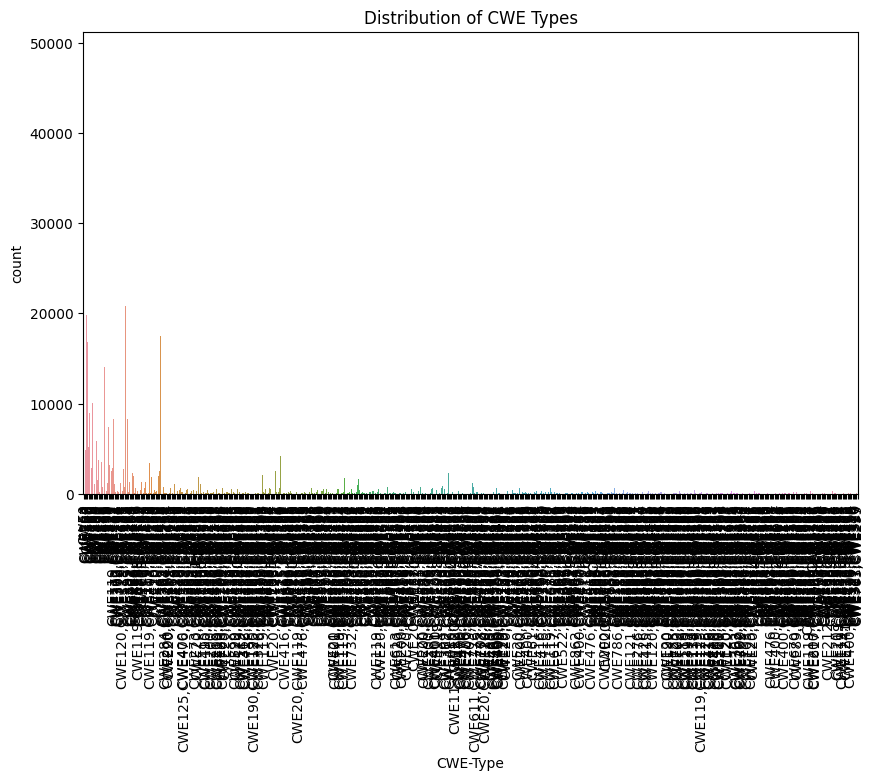

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizing the data distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CWE-Type')
plt.xticks(rotation=90)
plt.title('Distribution of CWE Types')
plt.show()

In [104]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [105]:
dataset = {}
dataset['text'] = list(df_train['code'])
dataset['label'] = list(df_train['label'])
ds = Dataset.from_dict(dataset)
ds = ds.train_test_split(test_size=0.1)

In [106]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm')

In [107]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = ds.map(preprocess_function, batched=True)

  0%|          | 0/238 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

In [108]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [109]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [110]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base-mlm", num_labels=626, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [111]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.290500,2.120025,0.526796


TrainOutput(global_step=14873, training_loss=2.9100044602898287, metrics={'train_runtime': 13107.8735, 'train_samples_per_second': 18.154, 'train_steps_per_second': 1.135, 'total_flos': 6.291736194309888e+16, 'train_loss': 2.9100044602898287, 'epoch': 1.0})

In [112]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [113]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [114]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                             precision    recall  f1-score   support

                       CWE0       0.54      0.78      0.64      9814
                    CWE1021       0.00      0.00      0.00        24
                     CWE113       0.00      0.00      0.00         4
  CWE113,CWE200,CWE94,CWE74       0.00      0.00      0.00         3
                     CWE116       0.00      0.00      0.00        44
               CWE116,CWE79       0.00      0.00      0.00         3
                    CWE1187       0.00      0.00      0.00        16
             CWE1187,CWE908       0.00      0.00      0.00         4
                     CWE119       0.48      0.63      0.55      1978
              CWE119,CWE125       0.82      0.30      0.44        76
       CWE119,CWE125,CWE120       0.00      0.00      0.00         4
       CWE119,CWE125,CWE295       0.00      0.00      0.00         9
       CWE119,CWE125,CWE703       0.00      0.00      0.00         6
CWE119,CWE125,CWE703,CWE787      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


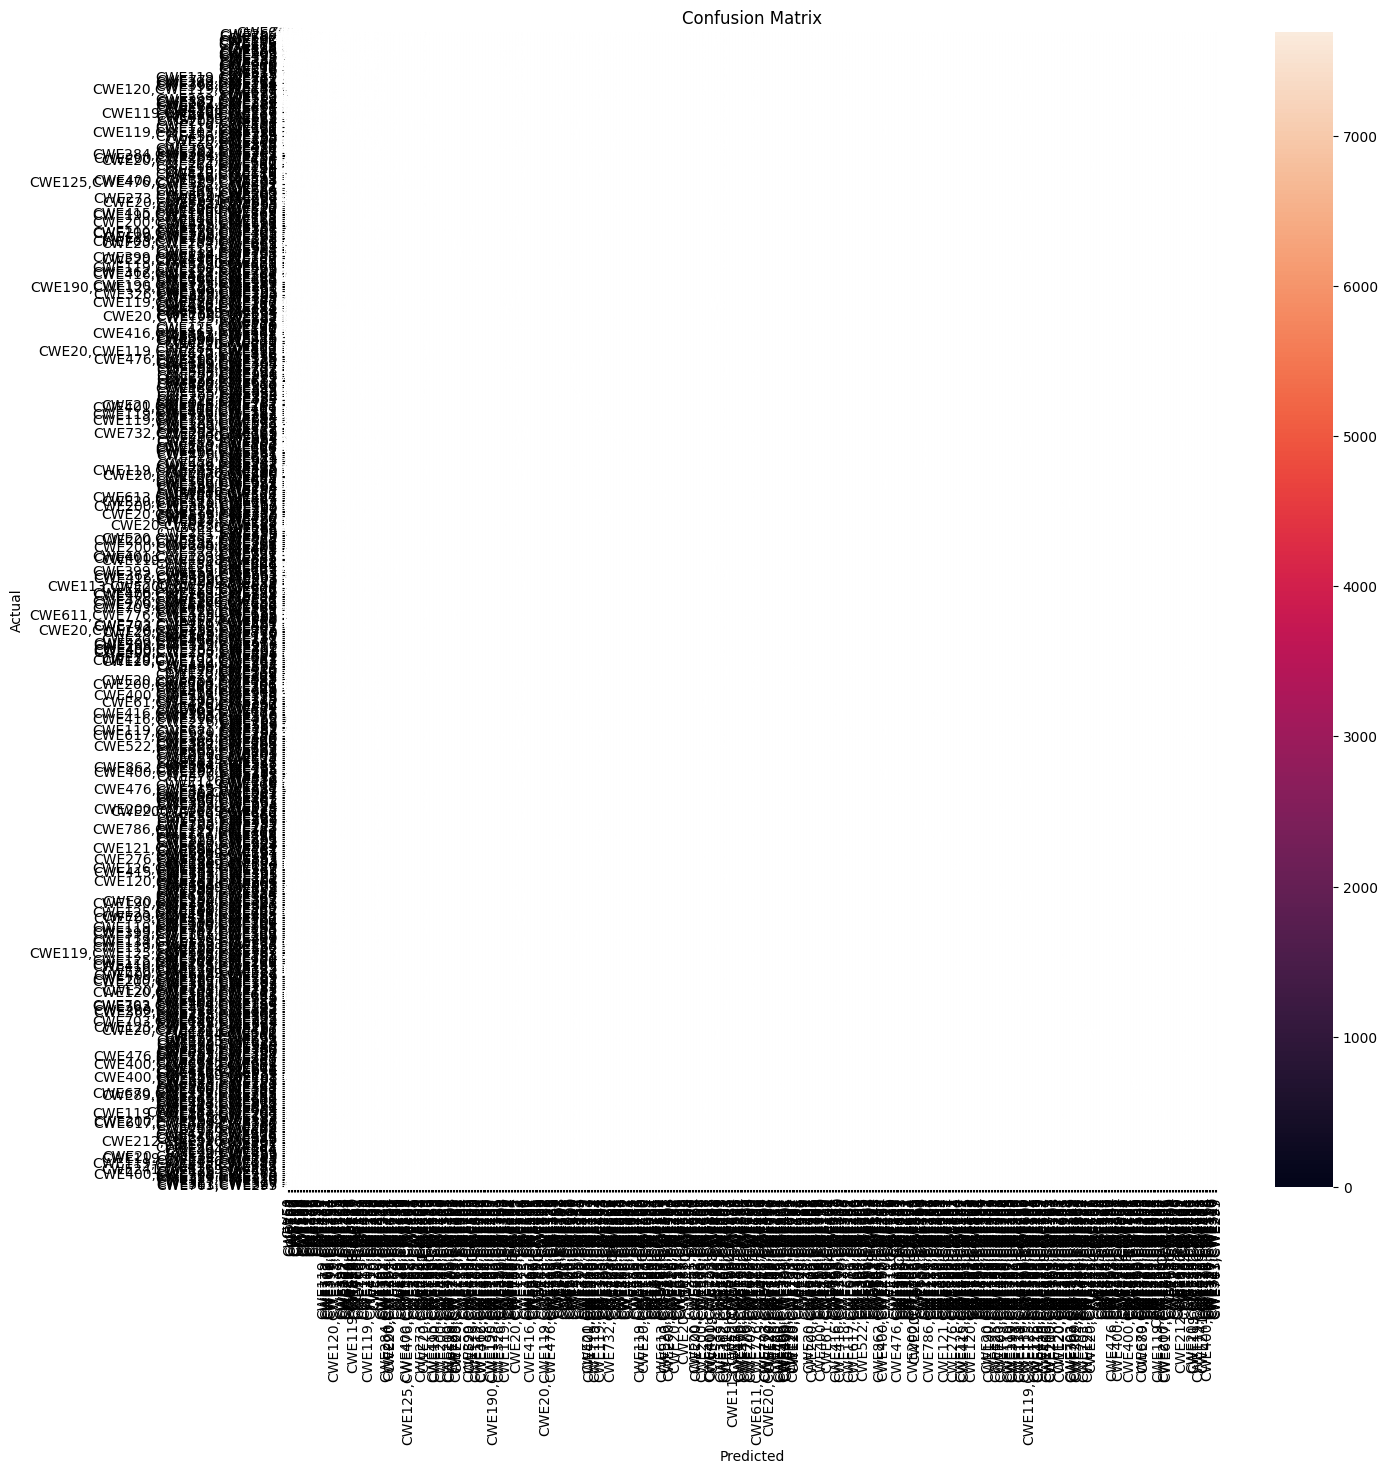

In [115]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()